In [4]:
%load_ext autoreload
%autoreload 2
from src.datasets.euclidean import Sphere3DDataset
import torch

n_points = 1000
dataset = Sphere3DDataset(n_points=1000, polar_angle_range=(0, 0.5 * torch.pi), azimuth_range=(0, 0.5 * torch.pi))

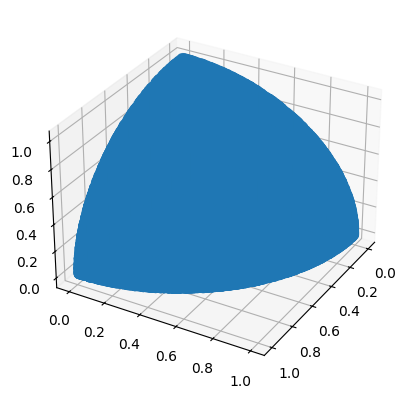

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset.points[:, 0], dataset.points[:, 1], dataset.points[:, 2])
ax.view_init(30, 30)
plt.show()

In [9]:
from src.datasets.euclidean import Sphere3DGeodesicsDataset
geodesics_dataset = Sphere3DGeodesicsDataset(dataset, target=torch.tensor([0., 0., 1.]))

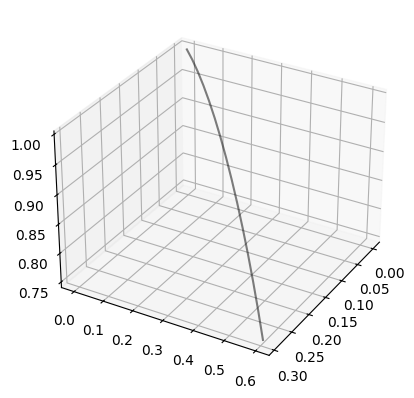

In [15]:
geodesic = geodesics_dataset.geodesics[0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(geodesic[:, 0], geodesic[:, 1], geodesic[:, 2], label='true', color='black', alpha=0.5)
ax.view_init(30, 30)
plt.show()

In [20]:
from src.datasets.base import DijkstraGeodesicsDataset
from src.manifolds.euclidean import Euclidean

base_manifold = Euclidean(d=3)
base_dataset = Sphere3DDataset(n_points=30, polar_angle_range=(0, 0.5 * torch.pi), azimuth_range=(0, 0.5 * torch.pi))

print(base_dataset.points.shape[0])


30


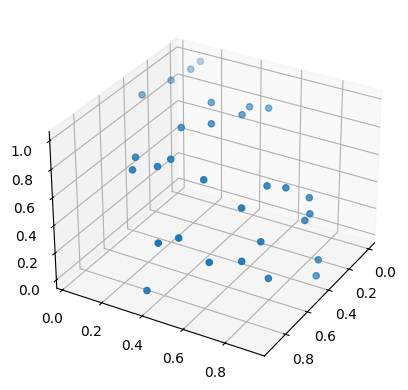

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(base_dataset.points[:, 0], base_dataset.points[:, 1], base_dataset.points[:, 2])
ax.view_init(30, 30)
plt.show()

In [22]:
dataset = DijkstraGeodesicsDataset(base_dataset, base_manifold)
import networkx as nx
graph = nx.from_numpy_array(dataset.dists)

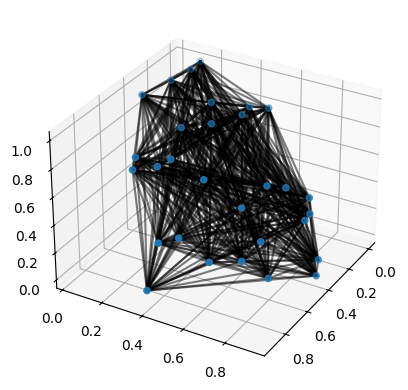

In [29]:
# plot graph edges
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(base_dataset.points[:, 0], base_dataset.points[:, 1], base_dataset.points[:, 2])
for edge in graph.edges:
    ax.plot([base_dataset.points[edge[0], 0], base_dataset.points[edge[1], 0]],
            [base_dataset.points[edge[0], 1], base_dataset.points[edge[1], 1]],
            [base_dataset.points[edge[0], 2], base_dataset.points[edge[1], 2]], color='black', alpha=0.5)
ax.view_init(30, 30)
plt.show()

In [ ]:
all_paths = nx.all_pairs_dijkstra(graph)
geodesics = []
visited_pairs = set()
for src, (dists, paths) in all_paths:
    for tgt, path in paths.items():
        conds = [(tgt, src) not in visited_pairs,
                 (src, tgt) not in visited_pairs,
                 src != tgt]
        if not all(conds):
            continue

        # if len(path) < self.path_length:
        #     continue
        # path = path[-self.path_length:]  # we take last path_length elements
        
        geodesic = base_dataset.points[path]
        geodesics.append(geodesic)
        visited_pairs.add((src, tgt))

In [ ]:
import numpy as np
from scipy.sparse import issparse
from scipy.sparse.csgraph import connected_components, shortest_path
from sklearn.neighbors import NearestNeighbors, kneighbors_graph, radius_neighbors_graph
from sklearn.utils.graph import _fix_connected_components
import warnings


def fit(X,
        n_neighbors=5,
        radius=None,
        n_components=2,  ### PCA
        eigen_solver="auto",  ### PCA
        tol=0,  ### PCA
        max_iter=None,   ### PCA
        path_method="auto",  ### shortest_path
        neighbors_algorithm="auto",
        n_jobs=None,
        metric="minkowski",
        p=2,
        metric_params=None):
    if n_neighbors is not None and radius is not None:
        raise ValueError(
            "Both n_neighbors and radius are provided. Use"
            f" Isomap(radius={radius}, n_neighbors=None) if intended to use"
            " radius-based neighbors"
        )
    
    # 1. Fit the nearest neighbors to construct the neighborhood graph
    nbrs_ = NearestNeighbors(
        n_neighbors=n_neighbors,
        radius=radius,
        algorithm=neighbors_algorithm,
        metric=metric,
        p=p,
        metric_params=metric_params,
        n_jobs=n_jobs,
    )
    nbrs_.fit(X)
    
    
    
    # Compute the number of connected components, and connect the different
    # components to be able to compute a shortest path between all pairs
    # of samples in the graph.
    # Similar fix to cluster._agglomerative._fix_connectivity.
    n_connected_components, labels = connected_components(nbg)
    if n_connected_components > 1:
        if metric == "precomputed" and issparse(X):
            raise RuntimeError(
                "The number of connected components of the neighbors graph"
                f" is {n_connected_components} > 1. The graph cannot be "
                "completed with metric='precomputed', and Isomap cannot be"
                "fitted. Increase the number of neighbors to avoid this "
                "issue, or precompute the full distance matrix instead "
                "of passing a sparse neighbors graph."
            )
        raise RuntimeError(
            (
                "The number of connected components of the neighbors graph "
                f"is {n_connected_components} > 1. Completing the graph to fit"
                " Isomap might be slow. Increase the number of neighbors to "
                "avoid this issue."
            ),
        )
    
        # use array validated by NearestNeighbors
        # nbg = _fix_connected_components(
        #     X=nbrs_._fit_X,
        #     graph=nbg,
        #     n_connected_components=n_connected_components,
        #     component_labels=labels,
        #     mode="distance",
        #     metric=nbrs_.effective_metric_,
        #     **nbrs_.effective_metric_params_,
        # )
    
    # dist_matrix_ = shortest_path(nbg, method=path_method, directed=False)
    # 
    # if nbrs_._fit_X.dtype == np.float32:
    #     dist_matrix_ = dist_matrix_.astype(
    #         nbrs_._fit_X.dtype, copy=False
    #     )
        
    return nbg

# G = dist_matrix_**2
# G *= -0.5

# self.embedding_ = self.kernel_pca_.fit_transform(G)
# self._n_features_out = self.embedding_.shape[1]

In [5]:
from scipy.sparse import issparse
from scipy.sparse.csgraph import connected_components
from sklearn.neighbors import NearestNeighbors, kneighbors_graph, radius_neighbors_graph

from src.datasets.base import BaseGeodesicsDataset

class ShortestPathGeodesicsDataset(BaseGeodesicsDataset):
    def __init__(self, base_dataset, base_manifold, nn_params, path_params):
        self.base_dataset = base_dataset
        self.base_manifold = base_manifold
        self.nn_params = nn_params
        self.nn_params['metric'] = 'precomputed'
        self.path_params = path_params
        self.path_params['directed'] = False

        self.nbg = None
        # assert path_length > 1, 'Max path length must be greater than 1'
        # self.path_length = path_length
        super().__init__()

    def generate_geodesics(self):
        # compute the pairwise distances between all pairs of conformations
        X = self.base_dataset.points  # we add single batch dim to make it [1, N, D]
        dists = self.base_manifold.pairwise_distance(X[None], X[None])  # dimensions: (1, N, N)
        dists = dists.squeeze(0)  # dimensions: (N, N)

        nbrs_ = NearestNeighbors(**self.nn_params)
        nbrs_.fit(dists)
        
        p = self.nn_params.copy()
        del p['algorithm']
        if self.nn_params['n_neighbors'] is not None:
            del p['radius']
            graph_init_fn = kneighbors_graph
        else:
            del p['n_neighbors']
            graph_init_fn = radius_neighbors_graph
            
        nbg = graph_init_fn(nbrs_, **p)
        
        n_connected_components, labels = connected_components(nbg)
        if n_connected_components > 1:
            if self.nn_params['metric'] == "precomputed" and issparse(X):
                raise RuntimeError(
                    "The number of connected components of the neighbors graph"
                    f" is {n_connected_components} > 1. The graph cannot be "
                    "completed with metric='precomputed', and Isomap cannot be"
                    "fitted. Increase the number of neighbors to avoid this "
                    "issue, or precompute the full distance matrix instead "
                    "of passing a sparse neighbors graph."
                )
            raise RuntimeError(
                (
                    "The number of connected components of the neighbors graph "
                    f"is {n_connected_components} > 1. Completing the graph to fit"
                    " Isomap might be slow. Increase the number of neighbors to "
                    "avoid this issue."
                ),
            )
        
        self.nbg = nbg
        
        # dist_matrix, predecessors = shortest_path(nbg, **self.path_params)
        geodesics = []
        return geodesics

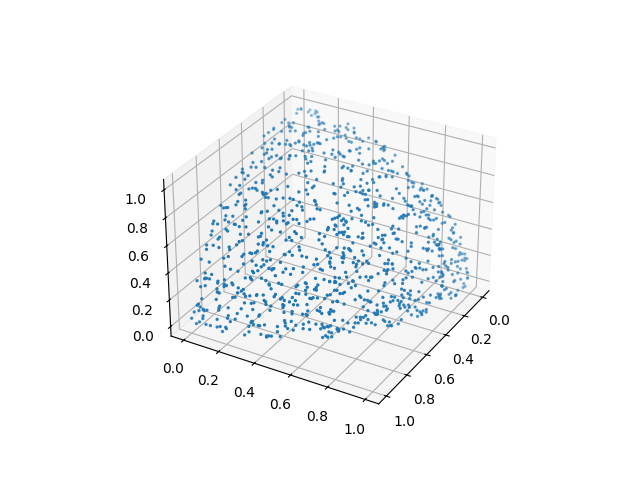

In [39]:
%matplotlib widget
import torch

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from src.manifolds.euclidean import Euclidean
from src.datasets.euclidean import Sphere3DDataset

base_manifold = Euclidean(d=3)
base_dataset = Sphere3DDataset(n_points=1000, polar_angle_range=(0, 0.5 * torch.pi), azimuth_range=(0, 0.5 * torch.pi))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(base_dataset.points[:, 0], base_dataset.points[:, 1], base_dataset.points[:, 2], s=2)
ax.view_init(30, 30)
plt.show()

In [7]:
import networkx as nx

example_nn_params = dict(n_neighbors=5,
                         radius=None,
                         algorithm='auto',
                         n_jobs=None)

example_path_params = dict(method='auto')

dataset = ShortestPathGeodesicsDataset(base_dataset, base_manifold, example_nn_params, example_path_params)
graph_dists = dataset.nbg

graph = nx.from_scipy_sparse_array(graph_dists)

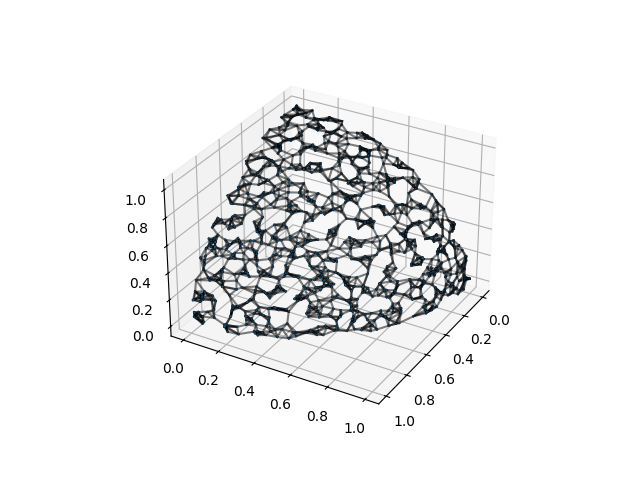

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(base_dataset.points[:, 0], base_dataset.points[:, 1], base_dataset.points[:, 2], s=0.1)
for edge in graph.edges:
    ax.plot([base_dataset.points[edge[0], 0], base_dataset.points[edge[1], 0]],
            [base_dataset.points[edge[0], 1], base_dataset.points[edge[1], 1]],
            [base_dataset.points[edge[0], 2], base_dataset.points[edge[1], 2]], color='black', alpha=0.5)
ax.view_init(30, 30)
plt.show()

In [29]:
import random

def extract_shortest_paths(graph, min_path_length=15, max_path_length=40, n_geodesics=10):
    all_paths = nx.all_pairs_dijkstra(graph)
    geodesic_paths = []
    visited_pairs = set()
    
    for src, (dists, paths) in all_paths:
        for tgt, path in paths.items():
            conds = [(tgt, src) not in visited_pairs,
                     (src, tgt) not in visited_pairs,
                     src != tgt]
            if not all(conds):
                continue
    
            if len(path) < min_path_length or len(path) > max_path_length:
                continue
    
            #path = path[-self.path_length:]  # we take last path_length elements
            
            geodesic_paths.append(path)
            visited_pairs.add((src, tgt))

    geodesic_samples = random.sample(geodesic_paths, n_geodesics)

    return geodesic_samples

50


/var/folders/jb/zsg_fyjs7ys046njbxjb7kch0000gn/T/ipykernel_11047/4275803845.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


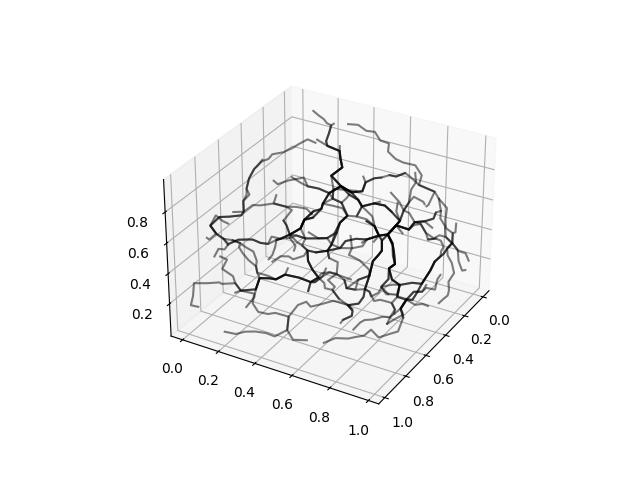

In [31]:
g_paths = extract_shortest_paths(graph, min_path_length=15, max_path_length=15, n_geodesics=50)
print(len(g_paths))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for path in g_paths:
    ax.plot(*base_dataset.points[path].unbind(dim=1), color='black', alpha=0.5)
ax.view_init(30, 30)
plt.show()

In [35]:
plt.close('all')